## Load Libraries and Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sqlite3
import string

In [24]:
# Import Dataset

df = pd.read_csv('train_preprocess.tsv.txt',sep='\t',names=['Kalimat','Label'])
df.head()

,Kalimat,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [25]:
# Row & Collumn Check
df.shape

(11000, 2)

In [26]:
# General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Kalimat  11000 non-null  object
 1   Label    11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


- Dataset consist 11000 row and 2 columns (`Kalimat` and `Label`)
- All data type is object (string)

## Missing and Duplicate Value Check

In [27]:
# Missing Value Check

df.isna().sum()

Kalimat    0
Label      0
dtype: int64

In [28]:
# Duplicate Data Check

print('There are {} duplicated data'.format(df.duplicated().sum()))

There are 67 duplicated data


In [7]:
# Drop Duplicate Data

#df = df.drop_duplicates()
#print('There are {} duplicated data'.format(df.duplicated().sum()))
#print('Duplicated data already dropped')

In [8]:
# Row and column check

#df.shape

- There are no missing values in dataset
- There are 67 duplicated in dataset and already dropped (consist 10933 row)

## EDA

In [29]:
# label distribution

df.Label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: Label, dtype: int64

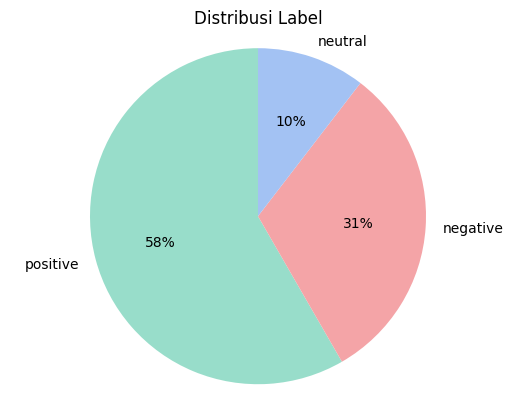

In [30]:
import matplotlib.pyplot as plt

# Data untuk pie chart
label_counts = df['Label'].value_counts()
labels = label_counts.index
sizes = label_counts.values

# Palet warna pastel
colors = ['#98ddca', '#f4a4a7', '#a3c2f3']

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90)

# Atur aspek lingkaran menjadi lingkaran (tidak terdistorsi)
ax.axis('equal')

# Tambahkan judul
ax.set_title('Distribusi Label')

# Tampilkan pie chart
plt.show()


In [31]:
# Create total word column

df['Total Word'] = df['Kalimat'].apply(lambda word: len(word.split()))

# Check new dataset

df.head()

,Kalimat,Label,Total Word
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,17
2,lokasi strategis di jalan sumatera bandung . t...,positive,33
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,38


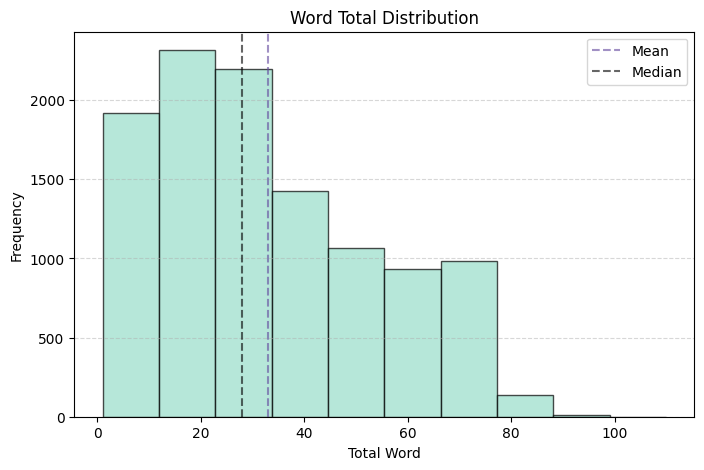

In [32]:
# Data distribution visualization

import matplotlib.pyplot as plt

# Palet warna
color = '#98ddca'

# Plot histogram
fig = plt.figure(figsize=(8, 5))
plt.hist(df['Total Word'], color=color, edgecolor='black', alpha=0.7)

# Garis vertikal untuk mean dan median
plt.axvline(x=df['Total Word'].mean(), ls='--', color='#62479e', alpha=0.6, label='Mean')
plt.axvline(x=df['Total Word'].median(), ls='--', color='black', alpha=0.6, label='Median')

# Judul dan label
plt.title('Word Total Distribution', size=12)
plt.xlabel('Total Word')
plt.ylabel('Frequency')

# Tambahkan grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Tampilkan legend
plt.legend()

# Tampilkan plot histogram
plt.show()


In [33]:
# Mean and median value from total word

print('Mean: {}'.format(df['Total Word'].mean()))
print('\t')
print('Median: {}'.format(df["Total Word"].median()))

Mean: 32.93127272727273
	
Median: 28.0


- The dataset consists 6383 (58%) positive labels, 3412 (31%) negative labels, and 1138 (10%) neutral labels
- Total word distribution is positive skew with majority in 20-30 words
- Mean and median from total word are 33 and 28 words

## Text Processing

We will do text preprocessing so that the text data becomes even more structured. For this, we will use RegEx library.

In [34]:
# Drop Total Word clumn

df = df.drop('Total Word', axis=1)

In [35]:
# Convert to lowercase

def lowercase(s):
    return s.lower()

In [36]:
# Remove punctuation

def punctuation(s):
    s = re.sub('((www\.[^\s]+)|(https?:\/\/[^\s]+)|(http?:\/\/[^\s]+)|(http[^\s]+))',' ', s) #menghapus semua URL
    s = re.sub(r'(?:\\x[A-Fa-f0-9]{2})+', r'', s) #menghapus \xDD substring
    s = re.sub('[^0-9a-zA-Z]+', ' ', s) #menghilangkan semua karakter yang bukan huruf atau angka dan menggantinya dengan spasi.
    s = re.sub(r'\brt\b',' ', s) #menghapus awalan rt
    s = re.sub('gue','saya', s) # Mengganti kata "gue" dengan kata "saya"
    #s = re.sub(r'\d+', '', s) #menghapus semua angka
    s = re.sub(r'\buser\b',' ', s) #menghapus kata 'user'
    s = re.sub(r':', ' ', s) #menggantikan karakter : dengan spasi 
    s = re.sub(' +', ' ', s) #menggantikan satu atau lebih spasi berturut-turut dengan satu spasi 
    s = re.sub('\n',' ',s) #menggantikan karakter newline (\n) dengan spasi 
    s = re.sub(r'pic.twitter.com.[\w]+', ' ', s) #menghapus semua tautan Twitter (pic.twitter.com)
    s = s.strip() #menghilangkan whitespace di awal dan di akhir teks
    return s


In addition to utilizing the regex library, we will enhance the standardization of non-standard words by leveraging the 'kamusalay' dictionary and RDBMS (SQlite).

In [37]:
# Create database connection

conn = sqlite3.connect('database.db')

In [38]:
# Import kamusalay

kamusalay = pd.read_csv('new_kamusalay.csv',encoding='latin-1',names=['alay','normal'])

# Connect kamusalay to database

kamusalay.to_sql('kamusalay', conn, if_exists='replace',index=False)
kamusalay=pd.DataFrame(kamusalay)
kamusalay

,alay,normal
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [19]:
# Retrive kamusalay

db = sqlite3.connect('database.db', check_same_thread= False)
q_kamusalay = 'SELECT * FROM kamusalay'
t_kamusalay = pd.read_sql_query(q_kamusalay, db)

In [20]:
# Change non standard words to become more standard words

alay_dict = dict(zip(t_kamusalay['alay'], t_kamusalay['normal']))
def alay_to_normal(s):
    #for word in alay_dict:
    return ' '.join([alay_dict[word] if word in alay_dict else word for word in s.split(' ')])

In [39]:
# Copy dataset

data = df.copy()
data.head()

,Kalimat,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [40]:
# Create text cleansing function

def cleansing(s):
    s= lowercase(s)
    s = punctuation(s)
    s = alay_to_normal(s)
    return s

In [41]:
# Apply cleansing function to dataset

data['Kalimat'] = data['Kalimat'].apply(cleansing)
data.head()


,Kalimat,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [44]:
# Old tweet and new tweet comparation

print('Old Tweet: {}'.format(df['Kalimat'].iloc[0]))
print('\t')
print('New Tweet: {}'.format(data['Kalimat'].iloc[0]))


Old Tweet: warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !
	
New Tweet: warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia harga cukup terjangkau jangan melewati tahu bletoka nya tidak kalah dengan yang asli dari tegal


## Data Storing

In [45]:
# Connect cleaned data to database

data.to_sql('data', conn, if_exists='replace', index=False)
data=pd.DataFrame(data)
data

,Kalimat,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai partai yang telah berkoalisi,neutral
10998,pagi pagi di tol pasteur sudah macet parah bik...,negative


In [46]:
# Close the database

conn.commit()
conn.close()